In [1]:
# Load Python libraries
from sklearn import model_selection, metrics, ensemble
from catboost import CatBoostClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# Load test data, add song and user's information
data_path = '/Users/lijiaqi/MAFM/6010S machine learning/CourseProject/data/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
songs = pd.read_csv(data_path + 'songs.csv')
members = pd.read_csv(data_path + 'members.csv')
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')

In [3]:
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_day'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['expiration_day'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))

# Drap date
members = members.drop(['registration_init_time','expiration_date'], 1)
members.head()

,msno,city,bd,gender,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011,8,20,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015,6,28,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016,4,11,2017,7,12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015,9,6,2015,9,7
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017,1,26,2017,6,13


In [4]:
# Since the dataset is too big, choose 1% of train as train dataset
train = train.sample(frac=0.01)
train = pd.merge(train, songs, on='song_id', how='left')
train = pd.merge(train, members, on='msno', how='left')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 22 columns):
msno                  73774 non-null object
song_id               73774 non-null object
source_system_tab     73534 non-null object
source_screen_name    69621 non-null object
source_type           73571 non-null object
target                73774 non-null int64
song_length           73773 non-null float64
genre_ids             72597 non-null object
artist_name           73773 non-null object
composer              57112 non-null object
lyricist              41990 non-null object
language              73773 non-null float64
city                  73774 non-null int64
bd                    73774 non-null int64
gender                44269 non-null object
registered_via        73774 non-null int64
registration_year     73774 non-null int64
registration_month    73774 non-null int64
registration_day      73774 non-null int64
expiration_year       73774 non-null int64
expiration_month 

In [5]:
# test dataset
test = pd.merge(test, songs, on='song_id', how='left')
test = pd.merge(test, members, on='msno', how='left')

In [6]:
# Count Na in %
train.isnull().sum()/train.isnull().count()*100
#test.isnull().sum()/test.isnull().count()*100

msno                   0.000000
song_id                0.000000
source_system_tab      0.325318
source_screen_name     5.629355
source_type            0.275165
target                 0.000000
song_length            0.001355
genre_ids              1.595413
artist_name            0.001355
composer              22.585193
lyricist              43.082929
language               0.001355
city                   0.000000
bd                     0.000000
gender                39.993765
registered_via         0.000000
registration_year      0.000000
registration_month     0.000000
registration_day       0.000000
expiration_year        0.000000
expiration_month       0.000000
expiration_day         0.000000
dtype: float64

In [7]:
# Replace NA
for i in train.select_dtypes(include=['object']).columns:
    train[i][train[i].isnull()] = 'unknown'
train = train.fillna(value=0)

In [8]:
for i in test.select_dtypes(include=['object']).columns:
    test[i][test[i].isnull()] = 'unknown'
test = test.fillna(value=0)

In [9]:
# Object data to category
for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].astype('category')
    
# Encoding categorical features
for col in train.select_dtypes(include=['category']).columns:
    train[col] = train[col].cat.codes
    

In [10]:
# Object data to category
for col in test.select_dtypes(include=['object']).columns:
    test[col] = test[col].astype('category')
    
# Encoding categorical features
for col in test.select_dtypes(include=['category']).columns:
    test[col] = test[col].cat.codes

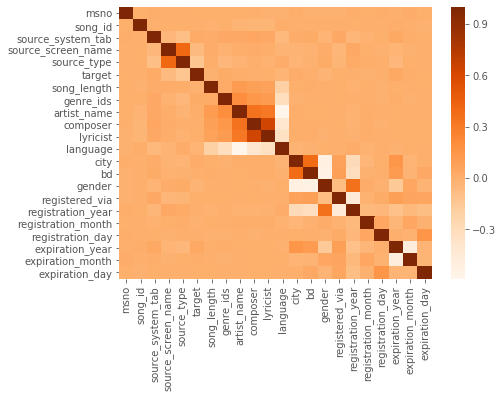

In [11]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(train.corr(),cmap="Oranges")
plt.show()

In [12]:
# Drop high correlation columns
train = train.drop(['lyricist'], 1)
test = test.drop(['lyricist'], 1)

In [13]:
# Train & Test split
target = train.pop('target')
train_data, val_data, train_labels, val_labels = model_selection.train_test_split(train, target, test_size = 0.2)

In [14]:
# Random Forest
# Create model
model1 = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model1.fit(train_data, train_labels)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
train_plot = pd.DataFrame({'features': train.columns,
                           'importances': model1.feature_importances_})
train_plot = train_plot.sort_values('importances', ascending=False)
train_plot

,features,importances
5,song_length,0.091730
1,song_id,0.090115
0,msno,0.088326
7,artist_name,0.082387
8,composer,0.076574
16,registration_day,0.068142
19,expiration_day,0.063639
15,registration_month,0.049755
3,source_screen_name,0.047876
4,source_type,0.046743


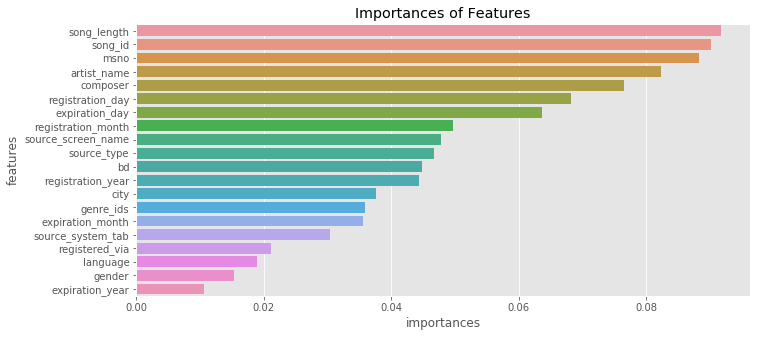

In [16]:
plt.figure(figsize=[11,5])
sns.barplot(x = train_plot.importances, y = train_plot.features)
plt.title('Importances of Features')
plt.show()

In [17]:
# Predicting
predict_labels1 = model1.predict(val_data)

print(metrics.classification_report(val_labels, predict_labels1))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      7204
           1       0.64      0.67      0.66      7551

    accuracy                           0.64     14755
   macro avg       0.64      0.64      0.64     14755
weighted avg       0.64      0.64      0.64     14755



In [18]:
# XG-Boosting
# Create model
model2 = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=250)
model2.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=10, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
train_plot = pd.DataFrame({'features': train.columns,
                           'importances': model2.feature_importances_})
train_plot = train_plot.sort_values('importances', ascending=False)
train_plot

,features,importances
4,source_type,0.308411
2,source_system_tab,0.076123
17,expiration_year,0.058677
3,source_screen_name,0.036761
9,language,0.036618
18,expiration_month,0.035084
8,composer,0.034182
6,genre_ids,0.034128
7,artist_name,0.032598
14,registration_year,0.032374


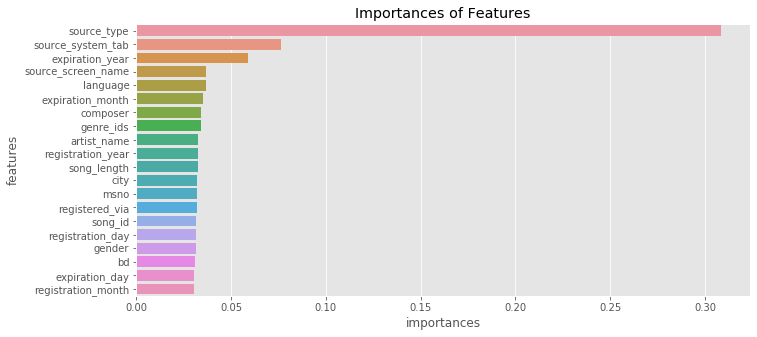

In [20]:
plt.figure(figsize=[11,5])
sns.barplot(x = train_plot.importances, y = train_plot.features)
plt.title('Importances of Features')
plt.show()

In [21]:
#Predicting
predict_labels2 = model2.predict(val_data)

print(metrics.classification_report(val_labels, predict_labels2))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62      7204
           1       0.64      0.67      0.65      7551

    accuracy                           0.64     14755
   macro avg       0.64      0.63      0.63     14755
weighted avg       0.64      0.64      0.64     14755



In [22]:
# CatBoost
#%%time
# Create model
model3 = CatBoostClassifier(learning_rate=0.1, depth=10, iterations=300,)
model3.fit(train_data, train_labels)

0:	learn: 0.6850468	total: 152ms	remaining: 45.4s
1:	learn: 0.6780556	total: 231ms	remaining: 34.4s
2:	learn: 0.6731226	total: 308ms	remaining: 30.5s
3:	learn: 0.6688233	total: 381ms	remaining: 28.2s
4:	learn: 0.6649183	total: 474ms	remaining: 28s
5:	learn: 0.6619163	total: 552ms	remaining: 27s
6:	learn: 0.6588660	total: 655ms	remaining: 27.4s
7:	learn: 0.6563027	total: 745ms	remaining: 27.2s
8:	learn: 0.6541421	total: 825ms	remaining: 26.7s
9:	learn: 0.6523032	total: 922ms	remaining: 26.7s
10:	learn: 0.6503232	total: 1s	remaining: 26.4s
11:	learn: 0.6485664	total: 1.11s	remaining: 26.8s
12:	learn: 0.6466064	total: 1.22s	remaining: 27s
13:	learn: 0.6448810	total: 1.31s	remaining: 26.8s
14:	learn: 0.6434597	total: 1.4s	remaining: 26.6s
15:	learn: 0.6421862	total: 1.48s	remaining: 26.3s
16:	learn: 0.6409437	total: 1.56s	remaining: 26s
17:	learn: 0.6399130	total: 1.65s	remaining: 25.9s
18:	learn: 0.6385256	total: 1.74s	remaining: 25.8s
19:	learn: 0.6374892	total: 1.82s	remaining: 25.5s
20

163:	learn: 0.5161673	total: 15.8s	remaining: 13.1s
164:	learn: 0.5157096	total: 15.9s	remaining: 13s
165:	learn: 0.5149498	total: 16s	remaining: 12.9s
166:	learn: 0.5143524	total: 16.1s	remaining: 12.8s
167:	learn: 0.5136490	total: 16.2s	remaining: 12.7s
168:	learn: 0.5130764	total: 16.3s	remaining: 12.6s
169:	learn: 0.5125816	total: 16.4s	remaining: 12.5s
170:	learn: 0.5120769	total: 16.5s	remaining: 12.4s
171:	learn: 0.5115797	total: 16.6s	remaining: 12.3s
172:	learn: 0.5111248	total: 16.7s	remaining: 12.2s
173:	learn: 0.5107523	total: 16.8s	remaining: 12.1s
174:	learn: 0.5102085	total: 16.9s	remaining: 12s
175:	learn: 0.5095655	total: 17s	remaining: 11.9s
176:	learn: 0.5091391	total: 17s	remaining: 11.8s
177:	learn: 0.5084511	total: 17.1s	remaining: 11.7s
178:	learn: 0.5076729	total: 17.2s	remaining: 11.7s
179:	learn: 0.5070828	total: 17.3s	remaining: 11.6s
180:	learn: 0.5063548	total: 17.4s	remaining: 11.5s
181:	learn: 0.5060313	total: 17.5s	remaining: 11.4s
182:	learn: 0.5054335	

In [23]:
train_plot = pd.DataFrame({'features': train.columns,
                           'importances': model3.feature_importances_})
train_plot = train_plot.sort_values('importances', ascending=False)
train_plot

,features,importances
5,song_length,7.332686
1,song_id,7.251516
8,composer,7.015718
0,msno,6.978090
16,registration_day,6.913154
4,source_type,6.600824
7,artist_name,6.588175
19,expiration_day,6.247481
15,registration_month,5.867227
3,source_screen_name,5.171848


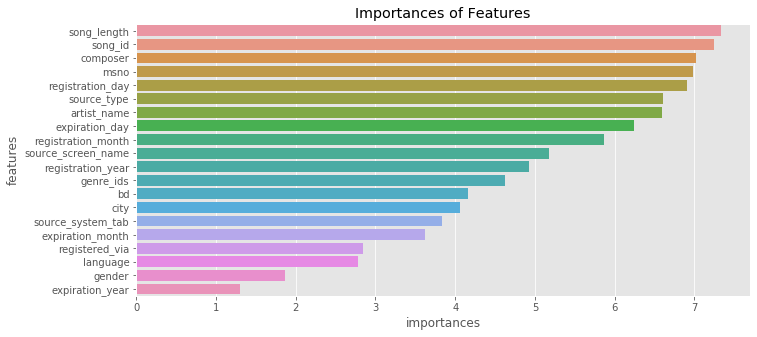

In [24]:
plt.figure(figsize=[11,5])
sns.barplot(x = train_plot.importances, y = train_plot.features)
plt.title('Importances of Features')
plt.show()

In [25]:
# Predicting
predict_labels3 = model3.predict(val_data)

print(metrics.classification_report(val_labels, predict_labels3))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61      7204
           1       0.63      0.66      0.64      7551

    accuracy                           0.63     14755
   macro avg       0.63      0.63      0.63     14755
weighted avg       0.63      0.63      0.63     14755



In [26]:
test = test.drop(['id'], 1)
test

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,language,city,bd,gender,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
0,12934,122191,3,8,3,224130.0,300,24890,33218,3.0,1,0,2,7,2016,2,19,2017,9,18
1,12934,217907,3,8,3,320470.0,306,24743,47677,3.0,1,0,2,7,2016,2,19,2017,9,18
2,712,37385,0,22,9,315899.0,158,21878,43194,17.0,1,0,2,4,2016,11,17,2016,11,24
3,1383,224360,5,16,7,285210.0,306,20718,39607,52.0,3,30,1,9,2007,7,25,2017,4,30
4,1383,85597,5,16,7,197590.0,429,21761,30731,-1.0,3,30,1,9,2007,7,25,2017,4,30
5,1383,89722,5,16,7,216372.0,306,11154,44009,31.0,3,30,1,9,2007,7,25,2017,4,30
6,1383,53843,5,16,7,200306.0,306,2750,20507,31.0,3,30,1,9,2007,7,25,2017,4,30
7,1383,74826,3,8,4,344305.0,300,23388,45499,3.0,3,30,1,9,2007,7,25,2017,4,30
8,1383,24520,5,16,7,289332.0,306,23486,45673,3.0,3,30,1,9,2007,7,25,2017,4,30
9,2176,69813,3,8,3,232176.0,306,1927,44009,31.0,1,0,2,7,2015,12,19,2017,9,18


In [27]:
predictions = model1.predict(test)

In [28]:
sample_subm = pd.read_csv(data_path + 'sample_submission.csv')
ids = sample_subm['id']

In [29]:
# Writing output to file
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = predictions
subm.to_csv(data_path + 'submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
